<a href="https://colab.research.google.com/github/m-costantini/Set-wise_Coordinate_Descent/blob/master/main_exact_vs_estimated_Lips_constants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code of Experiment B, exact vs estimated Lipschitz constants, in "Set-wise Coordinate Descent for Dual Asynchronous Decentralized Optimization", Marina Costantini, Nikolaos Liakopoulos, Panayotis Mertikopoulos, Thrasyvoulos Spyropoulos, submitted to IEEE Transactions on Automatic Control

Author: Marina Costantini

marina.costantini@eurecom.fr

August 2023

In [1]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab\ Notebooks/21_submissions/02_prepare_Trans_Auto_Control/')
!cp -R -u -p /content/drive/MyDrive/Colab\ Notebooks/21_submissions/02_prepare_Trans_Auto_Control/functions.py /content/
for mod_name in ["functions"]:
    if mod_name in sys.modules:
        del sys.modules[mod_name]
from functions import *


# Import common libraries
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Import my own functions
import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/Set-wise_Coordinate_Descent')

# New imports
!cp -R -u -p'/content/drive/MyDrive/Colab\ Notebooks/Set-wise_Coordinate_Descent'/{paral_distr_solvers.py,functions.py} /content/

for mod_name in ["paral_distr_solvers","functions"]:
    if mod_name in sys.modules:
        del sys.modules[mod_name]

from functions import *


cp: invalid option -- '/'
Try 'cp --help' for more information.


In [3]:
# Create dummy graph to distribute coordiantes - generate only the 12 nodes with set size 8
B = nx.watts_strogatz_graph(12, 8, 0)
G = np.array( nx.to_numpy_array(B) ).astype(int)
A = (get_edge_matrix(G)).astype(bool).T
coord_sets = []
for row in A:
    coord_sets.append( np.where(row)[0] )
E = np.shape(A)[1]


# Sanity check - see also in what sets each coordinate is
set_belonging = []
for row in A.T:
    set_belonging.append( np.where(row)[0] )

"""''' Problem and algorithm classes '''"""

class second_degree_problem():
    def __init__(self, E, coord_sets, power_2_coeff):
        self.E = E
        self.coord_sets = coord_sets
        self.power_2_coeff = power_2_coeff
        self.opt_val = 1
        self.Lips_vals = [2*coeff for coeff in power_2_coeff]

    def objective(self, x):
        return self.power_2_coeff @ x**2 + self.opt_val

    def coord_grad(self, x, i):
        return 2*self.power_2_coeff[i] * x[i]



class fourth_degree_problem():
    def __init__(self, E, coord_sets, power_4_coeff, start_val):
        self.E = E
        self.coord_sets = coord_sets
        self.set_size = len(coord_sets[0])
        self.power_4_coeff = power_4_coeff
        self.opt_val = 1
        self.Lips_vals = [12 * coeff * start_val**2 for coeff in power_4_coeff]

    def objective(self, x):
        return self.power_4_coeff @ x**4 + self.opt_val

    def coord_grad(self, x, i):
        return 4*self.power_4_coeff[i] * x[i]**3



class Distrib_SLCD():

    def __init__(self, the_problem, coord_sets, steps, start_val, flag_Lips_exact):
        self.the_problem = the_problem
        self.coord_sets = coord_sets
        self.steps = steps
        self.flag_Lips_exact = flag_Lips_exact
        self.n = len(coord_sets) # number of sets
        E = the_problem.E # number of coordiantes
        self.x = start_val*np.ones((E,))
        self.obj = np.zeros((steps,))

        self.Lips_estimated = np.zeros((E,))
        for e in range(E):
            grad_e = the_problem.coord_grad(self.x, e)
            L = self.estimate_L(e, self.x, grad_e, the_problem.coord_grad)
            self.Lips_estimated[e] = L


    def estimate_L(self, i, x, grad_i_val, grad_fun):
        L = 0.001/2
        grad_i_new = -grad_i_val # to make sure that we enter the loop below
        while grad_i_val * grad_i_new < 0 : # * product because we have scalars here
            L = 2*L
            x_new = np.copy(x)
            x_new[i] = x[i] - (1/L) * grad_i_val
            grad_i_new = grad_fun(x_new, i)
        L = 0.5 * L
        return L


    def choose_coordinate(self, i):
        if self.flag_Lips_exact:
            Lips_vals = self.the_problem.Lips_vals
        else:
            Lips_vals = self.Lips_estimated
        set_Lips = [Lips_vals[j] for j in self.coord_sets[i]]
        idx_e = np.random.choice(np.arange(0,len(set_Lips)), p=[Lj/sum(set_Lips) for Lj in set_Lips]) # proportional to Lipschitz value
        e = self.coord_sets[i][idx_e]
        return e


    def solve(self,):
        for t in range(self.steps):
            i = np.random.randint(self.n) # random set goes active
            e = self.choose_coordinate(i) # choose coordinate
            e_grad = self.the_problem.coord_grad(self.x, e)

            if self.flag_Lips_exact:
                L = self.the_problem.Lips_vals[e]
            else:
                L = self.estimate_L(e, self.x, e_grad, the_problem.coord_grad)
                self.Lips_estimated[e] = L
            self.x[e] = self.x[e] - (1/L) * e_grad
            self.obj[t] = self.the_problem.objective(self.x)

            if self.obj[t] > 10**10: # thing is diverging !
                print(' --> Objective > breaking_thresh @ iter ',t ,' --> break')
                break
            if abs(1 - self.obj[t]/self.the_problem.opt_val) < 10**(-9): # converged! stop!
                print(' --> Precision < 10^(-9) reached @ iter',t ,' --> leave!')
                self.obj = self.obj[:t]
                break
        return self.obj



"""''' Create problems and run algorithms '''"""


# Create problems
coeff_vals = np.random.randint(1, high=100, size=(E,))
start_val = 10
L_selec_list = ['exact', 'estimated']
order_poly_list = [2, 4]
# order_poly_list = [2]/
steps = 1000

obj_vals = {}
for order_poly in order_poly_list:
    print("Running sims with degree", order_poly)
    obj_vals[order_poly] = {}

    if order_poly == 2:
        the_problem = second_degree_problem(E, coord_sets, coeff_vals)
    else:
        the_problem = fourth_degree_problem(E, coord_sets, coeff_vals, start_val)

    for L_selec in L_selec_list:
        print("\tRunning sims with L", L_selec)
        if L_selec == 'exact':
            the_solver = Distrib_SLCD(the_problem, coord_sets, steps, start_val, True)
        else:
            the_solver = Distrib_SLCD(the_problem, coord_sets, steps, start_val, False)
        obj_vals[order_poly][L_selec] = the_solver.solve()



Running sims with degree 2
	Running sims with L exact
 --> Precision < 10^(-9) reached @ iter 861  --> leave!
	Running sims with L estimated
Running sims with degree 4
	Running sims with L exact
	Running sims with L estimated
 --> Precision < 10^(-9) reached @ iter 486  --> leave!


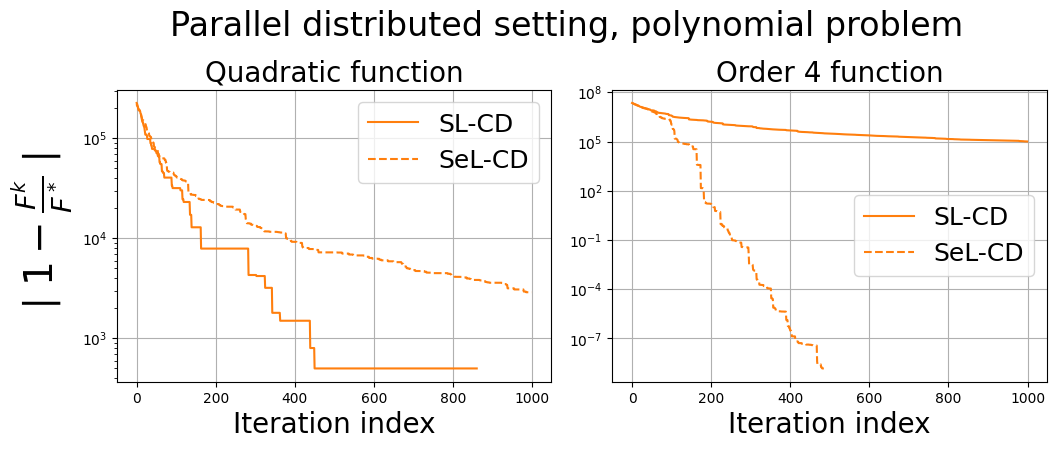

In [5]:
""" Plots """

fontsz = {'legends':18, 'axes':20, 'titles':20, 'suptitles':24}
# fontsz = {'legends':14, 'axes':16, 'titles':18, 'suptitles':20}

linestyles = {'exact': '-', 'estimated': '--'}
labels = {'exact': 'SL-CD', 'estimated': 'SeL-CD'}

fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=100)
for idx_poly, order_poly in enumerate(order_poly_list):
    for L_selec in L_selec_list:
        vals = obj_vals[order_poly][L_selec]
        suboptim = abs(1 - vals/the_problem.opt_val)
        ax[idx_poly].plot(suboptim, color='C1', linestyle=linestyles[L_selec], label=labels[L_selec])
    ax[idx_poly].set_xlabel('Iteration index', fontsize=fontsz['axes'])
    if idx_poly == 0:
        ax[idx_poly].set_ylabel(r'$ \mid 1 - \frac{F^k}{F^*} \mid $', fontsize=fontsz['axes']+8)
    ax[idx_poly].grid()
    if idx_poly == 0:
        title_str = 'Quadratic function'
        ax[idx_poly].legend(loc='upper right', fontsize=fontsz['legends'])
    else:
        title_str = 'Order 4 function'
        ax[idx_poly].legend(loc='center right', fontsize=fontsz['legends'])
    ax[idx_poly].set_title(title_str, fontsize=fontsz['titles'])
    ax[idx_poly].set_yscale("log")

fig.subplots_adjust(left = 0.125, right = 0.9, bottom = 0.05, top = 0.82, wspace = 0.14, hspace = 0.3)

suptitle_str = 'Parallel distributed setting, polynomial problem'
fig.suptitle(suptitle_str, fontsize=fontsz['suptitles'])

fig.subplots_adjust(
    left  = 0.125,  # the left side of the subplots of the figure
    right = 0.9,    # the right side of the subplots of the figure
    bottom = 0.05,   # the bottom of the subplots of the figure
    top = 0.78,      # the top of the subplots of the figure
    wspace = 0.14,   # the amount of width reserved for blank space between subplots
    hspace = 0.1)   # the amount of height reserved for white space between subplots